In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample

from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [69]:
conformal_metrics_vanilla = {
 "cutoff": [0.0, 0.005404300522059202, 0.033684518188238144, 0.05, 0.1, 0.2, 0.3, 0.3890679180622101, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95],
"coverage_naive": [0.7387387387387387, 0.7063318777292577, 0.6786885245901639, 0.6776429809358753, 0.6897880539499036, 0.6666666666666666, 0.6122448979591837, 0.6524590163934426, 0.6732673267326733, 0.6692307692307692, 0.6291666666666667, 0.5866666666666667, 0.5720930232558139, 0.599009900990099, 0.5906432748538012, 0.6186440677966102],
"coverage_cv_plus": [0.8124488124488124, 0.8220524017467249, 0.8081967213114755, 0.8318890814558059, 0.7880539499036608, 0.7952380952380952, 0.7784256559766763, 0.8622950819672132, 0.8250825082508251, 0.8384615384615385, 0.8166666666666667, 0.8177777777777778, 0.8325581395348837, 0.8811881188118812, 0.8713450292397661, 0.8305084745762712],
"coverage_jackknife_plus_ab": [0.7371007371007371, 0.7030567685589519, 0.6983606557377049, 0.7036395147313691, 0.6994219653179191, 0.65, 0.597667638483965, 0.6786885245901639, 0.6666666666666666, 0.6923076923076923, 0.6375, 0.6, 0.5953488372093023, 0.6386138613861386, 0.6198830409356725, 0.6101694915254238],
"interval_width_naive": [0.33615486145019524, 0.3936747789382934, 0.466556578874588, 0.49313491582870483, 0.487522155046463, 0.5079672932624817, 0.49069738388061523, 0.44034600257873535, 0.4177010893821716, 0.263324589729309, 0.1493734073638917, 0.15726344108581536, 0.14645690917968746, 0.10872319698333734, 0.11693801879882804, 0.08713016510009772],
"interval_width_cv_plus": [0.4668159315342589, 0.586368582336256, 0.7235728639830667, 0.7403800183014566, 0.7302039602808726, 0.7549307892043143, 0.7676098270888058, 0.7277213052921607, 0.7387384294998208, 0.5471554418948408, 0.4016485076894363, 0.35569797782037, 0.34765150171449016, 0.2791582903140547, 0.25024804303956305, 0.2040898787899543],
"interval_width_jackknife_plus_ab": [0.36039082529103555, 0.46384172792555495, 0.556070822257092, 0.5413734147596377, 0.539451971366545, 0.5724188050525243, 0.5658157869805662, 0.5073035879693213, 0.5271816855408832, 0.4149356539053507, 0.3260407831630946, 0.28178233859655377, 0.275307510405132, 0.2507502335634401, 0.24274082546734074, 0.18510055958909732]
}

conformal_metrics_full = {
 "cutoff": [0.0, 0.02019340731203556, 0.05, 0.08336329460144043, 0.1, 0.2, 0.3, 0.3942202627658844, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95],
"coverage_naive": [0.7452907452907452, 0.7417582417582418, 0.7130177514792899, 0.6967213114754098, 0.6843003412969283, 0.7184684684684685, 0.7402234636871509, 0.7275862068965517, 0.7047244094488189, 0.6533333333333333, 0.6313131313131313, 0.6538461538461539, 0.6692913385826772, 0.6019417475728155, 0.5777777777777777],
"coverage_cv_plus": [0.8026208026208026, 0.8274725274725274, 0.8239644970414202, 0.8114754098360656, 0.8020477815699659, 0.8175675675675675, 0.8100558659217877, 0.8172413793103448, 0.8267716535433071, 0.8088888888888889, 0.8232323232323232, 0.9038461538461539, 0.84251968503937, 0.8252427184466019, 0.8],
"coverage_jackknife_plus_ab": [0.7510237510237511, 0.743956043956044, 0.7366863905325444, 0.7081967213114754, 0.6945392491467577, 0.7117117117117117, 0.6927374301675978, 0.696551724137931, 0.6968503937007874, 0.6755555555555556, 0.6363636363636364, 0.6346153846153846, 0.6456692913385826, 0.7184466019417476, 0.6888888888888889],
"interval_width_naive": [0.322261244058609, 0.40983694791793823, 0.48056086897850037, 0.4802219867706299, 0.46945762634277344, 0.5350031852722168, 0.5142185688018799, 0.3193846702575684, 0.2116791915893554, 0.15133106946945185, 0.09953787326812737, 0.06926748275756832, 0.06730165958404541, 0.06365835905075065, 0.041161084175109774],
"interval_width_cv_plus": [0.4185412854836212, 0.5398344419704197, 0.6410543321871843, 0.6636718530707275, 0.6900948589100142, 0.6846545961404823, 0.6774929595878088, 0.5892208908485441, 0.4004148539921313, 0.3097164634916517, 0.20581690796547467, 0.15928808751396645, 0.13721544881974615, 0.12202947386983529, 0.08167739729748831],
"interval_width_jackknife_plus_ab": [0.36390308438205504, 0.44925150174469797, 0.5222394097007471, 0.5368396887135725, 0.5508325172156908, 0.5615734695823149, 0.5558552061604769, 0.4378218054687386, 0.3351707858856022, 0.2610127360180157, 0.18176604478649605, 0.1578344907225396, 0.1364895012324654, 0.1573999745364928, 0.12151573378974767]
}

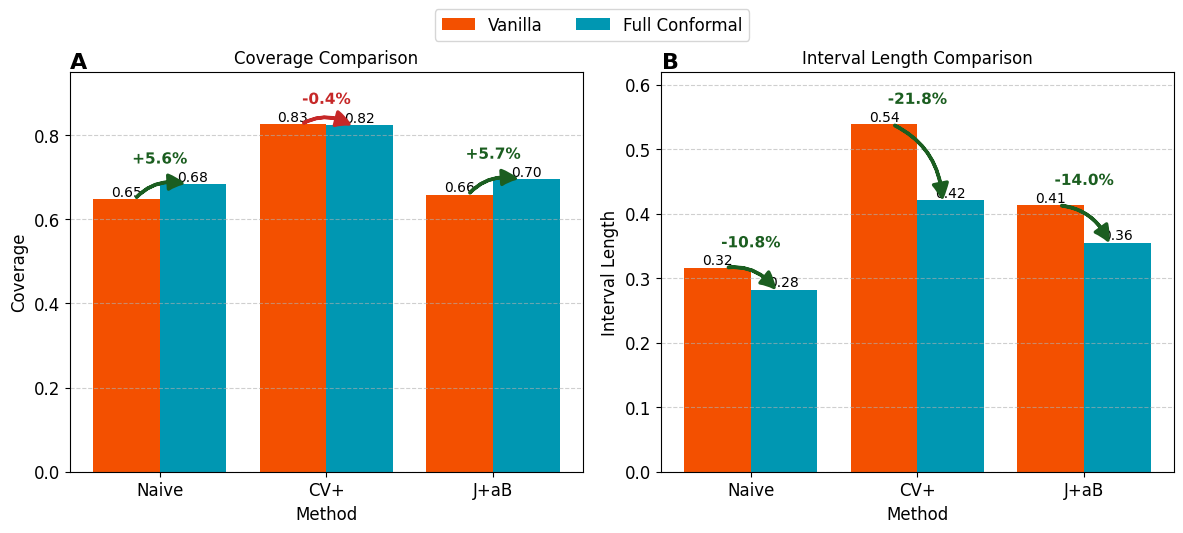

In [87]:
# Calculate averages for all metrics
def calculate_average_metrics(metrics_dict):
    avg_metrics = {
        'coverage_naive': np.mean(metrics_dict['coverage_naive']),
        'coverage_cv_plus': np.mean(metrics_dict['coverage_cv_plus']),
        'coverage_jackknife_plus_ab': np.mean(metrics_dict['coverage_jackknife_plus_ab']),
        'interval_width_naive': np.mean(metrics_dict['interval_width_naive']),
        'interval_width_cv_plus': np.mean(metrics_dict['interval_width_cv_plus']),
        'interval_width_jackknife_plus_ab': np.mean(metrics_dict['interval_width_jackknife_plus_ab'])
    }
    return avg_metrics

# Calculate the averages
vanilla_avg = calculate_average_metrics(conformal_metrics_vanilla)
full_avg = calculate_average_metrics(conformal_metrics_full)

# Calculate percentage differences
diff_coverage_naive = (full_avg['coverage_naive'] - vanilla_avg['coverage_naive']) / vanilla_avg['coverage_naive'] * 100
diff_coverage_cv_plus = (full_avg['coverage_cv_plus'] - vanilla_avg['coverage_cv_plus']) / vanilla_avg['coverage_cv_plus'] * 100
diff_coverage_jackknife = (full_avg['coverage_jackknife_plus_ab'] - vanilla_avg['coverage_jackknife_plus_ab']) / vanilla_avg['coverage_jackknife_plus_ab'] * 100

diff_interval_naive = (vanilla_avg['interval_width_naive'] - full_avg['interval_width_naive']) / vanilla_avg['interval_width_naive'] * 100
diff_interval_cv_plus = (vanilla_avg['interval_width_cv_plus'] - full_avg['interval_width_cv_plus']) / vanilla_avg['interval_width_cv_plus'] * 100
diff_interval_jackknife = (vanilla_avg['interval_width_jackknife_plus_ab'] - full_avg['interval_width_jackknife_plus_ab']) / vanilla_avg['interval_width_jackknife_plus_ab'] * 100

# Print the averages and differences for verification
# print("Average Metrics:")
# print(f"Vanilla Naive - Coverage: {vanilla_avg['coverage_naive']:.4f}, Interval: {vanilla_avg['interval_width_naive']:.4f}")
# print(f"Full Naive - Coverage: {full_avg['coverage_naive']:.4f}, Interval: {full_avg['interval_width_naive']:.4f}")
# print(f"Diff - Coverage: {diff_coverage_naive:.1f}%, Interval: {diff_interval_naive:.1f}%")

# print(f"Vanilla CV+ - Coverage: {vanilla_avg['coverage_cv_plus']:.4f}, Interval: {vanilla_avg['interval_width_cv_plus']:.4f}")
# print(f"Full CV+ - Coverage: {full_avg['coverage_cv_plus']:.4f}, Interval: {full_avg['interval_width_cv_plus']:.4f}")
# print(f"Diff - Coverage: {diff_coverage_cv_plus:.1f}%, Interval: {diff_interval_cv_plus:.1f}%")

# print(f"Vanilla J+aB - Coverage: {vanilla_avg['coverage_jackknife_plus_ab']:.4f}, Interval: {vanilla_avg['interval_width_jackknife_plus_ab']:.4f}")
# print(f"Full J+aB - Coverage: {full_avg['coverage_jackknife_plus_ab']:.4f}, Interval: {full_avg['interval_width_jackknife_plus_ab']:.4f}")
# print(f"Diff - Coverage: {diff_coverage_jackknife:.1f}%, Interval: {diff_interval_jackknife:.1f}%")

# Create the visualization
width = 0.4  # Adjusted bar width
methods = ['Naive', 'CV+', 'J+aB']
x = np.arange(len(methods))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# fig.suptitle('Vanilla vs Full Conformal: Average Performance', fontsize=18, weight='bold')

# Coverage Comparison
vanilla_coverage = [vanilla_avg['coverage_naive'], vanilla_avg['coverage_cv_plus'], vanilla_avg['coverage_jackknife_plus_ab']]
full_coverage = [full_avg['coverage_naive'], full_avg['coverage_cv_plus'], full_avg['coverage_jackknife_plus_ab']]

# Reversed order: Vanilla first, then Full Conformal
bar1 = ax1.bar(x - width/2, vanilla_coverage, width, label='Vanilla', color='#F35000')
bar2 = ax1.bar(x + width/2, full_coverage, width, label='Full Conformal', color='#0097B2')

def add_value_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10)

add_value_labels(bar1, ax1)
add_value_labels(bar2, ax1)

# Set y-axis limits with padding for annotations
max_coverage = max(max(vanilla_coverage), max(full_coverage))
ax1.set_ylim(0, max_coverage * 1.15)  # Add 15% padding

ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=12)
ax1.set_xlabel('Method', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.set_title('Coverage Comparison', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Interval Width Comparison
vanilla_interval = [vanilla_avg['interval_width_naive'], vanilla_avg['interval_width_cv_plus'], vanilla_avg['interval_width_jackknife_plus_ab']]
full_interval = [full_avg['interval_width_naive'], full_avg['interval_width_cv_plus'], full_avg['interval_width_jackknife_plus_ab']]

# Reversed order: Vanilla first, then Full Conformal
bar3 = ax2.bar(x - width/2, vanilla_interval, width, color='#F35000')
bar4 = ax2.bar(x + width/2, full_interval, width, color='#0097B2')

add_value_labels(bar3, ax2)
add_value_labels(bar4, ax2)

# Set y-axis limits with padding for annotations
max_interval = max(max(vanilla_interval), max(full_interval))
ax2.set_ylim(0, max_interval * 1.15)  # Add 15% padding

ax2.set_xticks(x)
ax2.set_xticklabels(methods, fontsize=12)
ax2.set_xlabel('Method', fontsize=12)
ax2.set_ylabel('Interval Length', fontsize=12)
ax2.set_title('Interval Length Comparison', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.6)

# Define annotation properties
bbox_props = dict(boxstyle="round,pad=0.3", fc='#C8E6C9', ec="none", alpha=0.6)

# Add curved arrows and percentage difference annotations
from matplotlib.patches import FancyArrowPatch
import matplotlib.patheffects as PathEffects

coverage_diffs = [diff_coverage_naive, diff_coverage_cv_plus, diff_coverage_jackknife]
interval_diffs = [diff_interval_naive, diff_interval_cv_plus, diff_interval_jackknife]

# Define arrow styles
arrow_style = "simple,head_width=10,head_length=10"
arrow_linewidth = 2.5
pos_color = '#1B5E20'  # Green
neg_color = '#C62828'  # Red

for i, (diff_cov, diff_int) in enumerate(zip(coverage_diffs, interval_diffs)):
    # Coverage arrows and annotations
    vanilla_bar_top = vanilla_coverage[i]
    full_bar_top = full_coverage[i]
    arrow_center_x = x[i]
    
    # Determine arrow positions and directions for coverage
    if diff_cov > 0:  # Full conformal has better coverage (upward arrow)
        # Draw curved arrow from vanilla to full conformal (curves upward)
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        
        # Add text with percentage improvement
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + (max_coverage * 0.05),
                f'+{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=11, color=pos_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    else:  # Vanilla has better coverage (downward arrow)
        # Draw curved arrow from vanilla to full conformal (curves downward)
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=neg_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        
        # Add text with percentage decrease
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + (max_coverage * 0.05),
                f'{diff_cov:.1f}%', ha='center', va='bottom', 
                fontsize=11, color=neg_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    
    # Interval width arrows and annotations
    vanilla_bar_top_int = vanilla_interval[i]
    full_bar_top_int = full_interval[i]
    
    # Determine arrow positions and directions for interval width
    if diff_int > 0:  # Full conformal has shorter interval (better) - downward arrow
        # Draw curved arrow from vanilla to full conformal (curves downward)
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top_int), 
            (arrow_center_x + width/2 - 0.05, full_bar_top_int),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax2.add_patch(arrow)
        
        # Add text with percentage improvement
        text = ax2.text(arrow_center_x, max(vanilla_bar_top_int, full_bar_top_int) + (max_interval * 0.05),
                f'-{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=11, color=pos_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    else:  # Vanilla has shorter interval - upward arrow
        # Draw curved arrow from vanilla to full conformal (curves upward)
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top_int), 
            (arrow_center_x + width/2 - 0.05, full_bar_top_int),
            connectionstyle=f"arc3,rad=0.3", 
            arrowstyle=arrow_style, 
            color=neg_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax2.add_patch(arrow)
        
        # Add text with percentage decrease
        text = ax2.text(arrow_center_x, max(vanilla_bar_top_int, full_bar_top_int) + (max_interval * 0.05),
                f'+{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=11, color=neg_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

# Add legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12, 
          bbox_to_anchor=(0.5, 0.95), frameon=True)

# Add letters A and B to the subplots
ax1.text(0.035, 1.05, 'A', transform=ax1.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(0.035, 1.05, 'B', transform=ax2.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')

# Add summary text box at the bottom
summary_text = "Summary: Full Conformal outperforms Vanilla with CV+ showing the largest interval reduction (21.8%)\nwhile maintaining equivalent coverage. Naive and J+aB show improved coverage (5-6%) with shorter intervals (10-14%)."
# fig.text(0.5, 0.01, summary_text, ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.5", fc='#E3F2FD', ec='#1976D2'))

# Adjust layout and show
plt.tight_layout(rect=[0, 0.05, 1, 0.9])
# plt.savefig('method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Adjusted arrow parameters for better transitions
arrow_style = "simple,head_width=8,head_length=10"
arrow_linewidth = 2.5  # Slightly thinner arrows for better aesthetics
arrow_curvature = -0.2  # Adjusted curvature for smoother transitions

for i, (diff_cov, diff_int) in enumerate(zip(coverage_diffs, interval_diffs)):
    # Coverage arrows and annotations
    vanilla_bar_top = vanilla_coverage[i]
    full_bar_top = full_coverage[i]
    arrow_center_x = x[i]
    
    # Adjust arrow curvature and positioning for coverage
    if diff_cov > 0:  # Full conformal has better coverage (upward arrow)
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad={arrow_curvature}", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                 f'+{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                 fontsize=11, color=pos_color, fontweight='bold')
    elif diff_cov < 0:  # Vanilla has better coverage (downward arrow)
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad={arrow_curvature}", 
            arrowstyle=arrow_style, 
            color=neg_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                 f'{diff_cov:.1f}%', ha='center', va='bottom', 
                 fontsize=11, color=neg_color, fontweight='bold')
    
    # Interval width arrows and annotations
    vanilla_bar_top_int = vanilla_interval[i]
    full_bar_top_int = full_interval[i]
    
    # Adjust arrow curvature and positioning for interval width
    if diff_int > 0:  # Full conformal has shorter interval (better)
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top_int), 
            (arrow_center_x + width/2 - 0.05, full_bar_top_int),
            connectionstyle=f"arc3,rad={arrow_curvature}", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax2.add_patch(arrow)
        ax2.text(arrow_center_x, max(vanilla_bar_top_int, full_bar_top_int) + 0.03,
                 f'-{abs(diff_int):.1f}%', ha='center', va='bottom', 
                 fontsize=11, color=pos_color, fontweight='bold')
    else:  # Vanilla has shorter interval
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top_int), 
            (arrow_center_x + width/2 - 0.05, full_bar_top_int),
            connectionstyle=f"arc3,rad={arrow_curvature}", 
            arrowstyle=arrow_style, 
            color=neg_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax2.add_patch(arrow)
        ax2.text(arrow_center_x, max(vanilla_bar_top_int, full_bar_top_int) + 0.03,
                 f'+{abs(diff_int):.1f}%', ha='center', va='bottom', 
                 fontsize=11, color=neg_color, fontweight='bold')

# Redraw the plots to reflect the changes
plt.show()

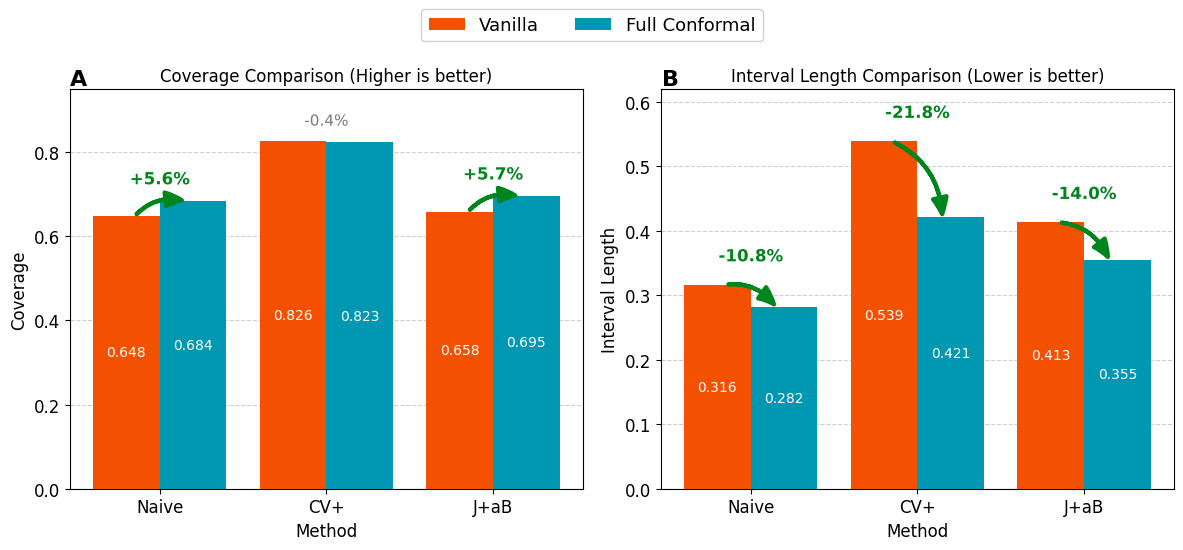

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import matplotlib.patheffects as PathEffects

# Calculate averages for all metrics
def calculate_average_metrics(metrics_dict):
    avg_metrics = {
        'coverage_naive': np.mean(metrics_dict['coverage_naive']),
        'coverage_cv_plus': np.mean(metrics_dict['coverage_cv_plus']),
        'coverage_jackknife_plus_ab': np.mean(metrics_dict['coverage_jackknife_plus_ab']),
        'interval_width_naive': np.mean(metrics_dict['interval_width_naive']),
        'interval_width_cv_plus': np.mean(metrics_dict['interval_width_cv_plus']),
        'interval_width_jackknife_plus_ab': np.mean(metrics_dict['interval_width_jackknife_plus_ab'])
    }
    return avg_metrics

# Calculate the averages
vanilla_avg = calculate_average_metrics(conformal_metrics_vanilla)
full_avg = calculate_average_metrics(conformal_metrics_full)

# Calculate percentage differences
diff_coverage_naive = (full_avg['coverage_naive'] - vanilla_avg['coverage_naive']) / vanilla_avg['coverage_naive'] * 100
diff_coverage_cv_plus = (full_avg['coverage_cv_plus'] - vanilla_avg['coverage_cv_plus']) / vanilla_avg['coverage_cv_plus'] * 100
diff_coverage_jackknife = (full_avg['coverage_jackknife_plus_ab'] - vanilla_avg['coverage_jackknife_plus_ab']) / vanilla_avg['coverage_jackknife_plus_ab'] * 100

diff_interval_naive = (vanilla_avg['interval_width_naive'] - full_avg['interval_width_naive']) / vanilla_avg['interval_width_naive'] * 100
diff_interval_cv_plus = (vanilla_avg['interval_width_cv_plus'] - full_avg['interval_width_cv_plus']) / vanilla_avg['interval_width_cv_plus'] * 100
diff_interval_jackknife = (vanilla_avg['interval_width_jackknife_plus_ab'] - full_avg['interval_width_jackknife_plus_ab']) / vanilla_avg['interval_width_jackknife_plus_ab'] * 100

# Create the visualization with improved styling
width = 0.4  # Adjusted bar width
methods = ['Naive', 'CV+', 'J+aB']
x = np.arange(len(methods))

# Set up color scheme with more saturated colors for better emphasis
vanilla_color = '#F35000'  # Vibrant orange
conformal_color = '#0097B2'  # Vibrant teal
pos_color = '#00851D'  # Stronger green for better visibility
neg_color = '#D01C1C'  # Stronger red for better visibility

# Create figure with improved proportions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.rcParams.update({'font.size': 12})  # Increase base font size

# === COVERAGE COMPARISON (Panel A) ===
vanilla_coverage = [vanilla_avg['coverage_naive'], vanilla_avg['coverage_cv_plus'], vanilla_avg['coverage_jackknife_plus_ab']]
full_coverage = [full_avg['coverage_naive'], full_avg['coverage_cv_plus'], full_avg['coverage_jackknife_plus_ab']]

# Format values to 3 decimal places for consistency
vanilla_coverage_formatted = [f"{val:.3f}" for val in vanilla_coverage]
full_coverage_formatted = [f"{val:.3f}" for val in full_coverage]

bar1 = ax1.bar(x - width/2, vanilla_coverage, width, label='Vanilla', color=vanilla_color, zorder=5)
bar2 = ax1.bar(x + width/2, full_coverage, width, label='Full Conformal', color=conformal_color, zorder=5)

# Function to add centered labels in bars
def add_centered_labels(bars, formatted_values, ax):
    for bar, value in zip(bars, formatted_values):
        height = bar.get_height()
        # Position labels in the middle of the bars
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                value, ha='center', va='center', fontsize=10, zorder=10,
                color='white')  # White text for contrast

add_centered_labels(bar1, vanilla_coverage_formatted, ax1)
add_centered_labels(bar2, full_coverage_formatted, ax1)

# Set coverage y-axis to start at 0 for accurate visual comparison
ax1.set_ylim(0, max(max(vanilla_coverage), max(full_coverage)) * 1.15)  # Increased padding for labels

ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=12)
ax1.set_xlabel('Method', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.set_title('Coverage Comparison (Higher is better)', fontsize=12)

# Reduce number of grid lines for less clutter
ax1.grid(axis='y', linestyle='--', alpha=0.6)
ax1.set_axisbelow(True)  # Ensure grid is behind bars

# === INTERVAL WIDTH COMPARISON (Panel B) ===
vanilla_interval = [vanilla_avg['interval_width_naive'], vanilla_avg['interval_width_cv_plus'], vanilla_avg['interval_width_jackknife_plus_ab']]
full_interval = [full_avg['interval_width_naive'], full_avg['interval_width_cv_plus'], full_avg['interval_width_jackknife_plus_ab']]

# Format values to 3 decimal places for consistency
vanilla_interval_formatted = [f"{val:.3f}" for val in vanilla_interval]
full_interval_formatted = [f"{val:.3f}" for val in full_interval]

bar3 = ax2.bar(x - width/2, vanilla_interval, width, color=vanilla_color, zorder=5)
bar4 = ax2.bar(x + width/2, full_interval, width, color=conformal_color, zorder=5)

add_centered_labels(bar3, vanilla_interval_formatted, ax2)
add_centered_labels(bar4, full_interval_formatted, ax2)

# Set interval y-axis to start at 0
ax2.set_ylim(0, max(max(vanilla_interval), max(full_interval)) * 1.15)  # Increased padding for labels

ax2.set_xticks(x)
ax2.set_xticklabels(methods, fontsize=12)
ax2.set_xlabel('Method', fontsize=12)
ax2.set_ylabel('Interval Length', fontsize=12)
ax2.set_title('Interval Length Comparison (Lower is better)', fontsize=12)

# Reduce number of grid lines for less clutter
ax2.grid(axis='y', linestyle='--', alpha=0.6)
ax2.set_axisbelow(True)  # Ensure grid is behind bars

# === IMPROVED ARROWS AND LABELS ===
# Define consistent arrow parameters
arrow_style = "simple,head_width=10,head_length=12"
arrow_linewidth = 3.0  # Thicker arrows for better visibility

# Add curved arrows with consistent curvature and improved positioning
coverage_diffs = [diff_coverage_naive, diff_coverage_cv_plus, diff_coverage_jackknife]
interval_diffs = [diff_interval_naive, diff_interval_cv_plus, diff_interval_jackknife]

for i, (diff_cov, diff_int) in enumerate(zip(coverage_diffs, interval_diffs)):
    # Coverage arrows and annotations
    vanilla_bar_top = vanilla_coverage[i]
    full_bar_top = full_coverage[i]
    arrow_center_x = x[i]
    
    # Use consistent curvature for all arrows (-0.3 rad)
    # For coverage: higher is better
    if diff_cov > 1.0:  # Only show significant improvements (>1%)
        # Draw curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        
        # Add text with percentage improvement
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'+{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=12, color=pos_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='white')])
    elif diff_cov < -1.0:  # Only show significant decreases (<-1%)
        # Draw curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=neg_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        
        # Add text with percentage decrease
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'{diff_cov:.1f}%', ha='center', va='bottom', 
                fontsize=12, color=neg_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='white')])
    else:
        # For the -0.4% case (essentially equivalent), show a muted label
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'{diff_cov:.1f}%', ha='center', va='bottom', 
                fontsize=11, color='#666666', fontweight='normal', alpha=0.8)
        text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='white')])
    
    # Interval width arrows and annotations
    vanilla_bar_top_int = vanilla_interval[i]
    full_bar_top_int = full_interval[i]
    
    # For interval: lower is better
    if diff_int > 0:  # Full conformal has shorter interval (better)
        # Draw curved arrow from vanilla to full conformal (consistency in curves)
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top_int), 
            (arrow_center_x + width/2 - 0.05, full_bar_top_int),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax2.add_patch(arrow)
        
        # Add text with percentage improvement
        text = ax2.text(arrow_center_x, max(vanilla_bar_top_int, full_bar_top_int) + 0.03,
                f'-{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=12, color=pos_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='white')])
    else:  # Vanilla has shorter interval
        # Draw curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top_int), 
            (arrow_center_x + width/2 - 0.05, full_bar_top_int),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=neg_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax2.add_patch(arrow)
        
        # Add text with percentage decrease
        text = ax2.text(arrow_center_x, max(vanilla_bar_top_int, full_bar_top_int) + 0.03,
                f'+{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=12, color=neg_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='white')])

# Add legend with improved position and styling
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=13, 
          bbox_to_anchor=(0.5, 0.98), frameon=True, framealpha=0.9, edgecolor='#CCCCCC')

# Add letters A and B to the subplots
ax1.text(0.035, 1.05, 'A', transform=ax1.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(0.035, 1.05, 'B', transform=ax2.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')


# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.9])

# Save with higher resolution
# plt.savefig('improved_method_comparison_centered_labels.png', dpi=400, bbox_inches='tight')
plt.show()

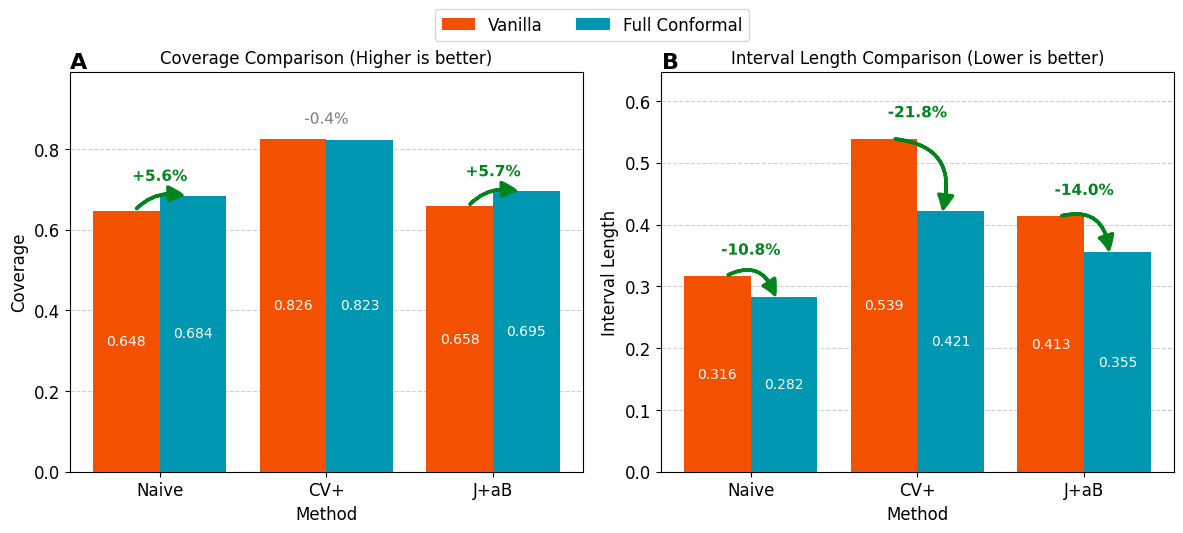

In [124]:
# Calculate averages for all metrics
def calculate_average_metrics(metrics_dict):
    avg_metrics = {
        'coverage_naive': np.mean(metrics_dict['coverage_naive']),
        'coverage_cv_plus': np.mean(metrics_dict['coverage_cv_plus']),
        'coverage_jackknife_plus_ab': np.mean(metrics_dict['coverage_jackknife_plus_ab']),
        'interval_width_naive': np.mean(metrics_dict['interval_width_naive']),
        'interval_width_cv_plus': np.mean(metrics_dict['interval_width_cv_plus']),
        'interval_width_jackknife_plus_ab': np.mean(metrics_dict['interval_width_jackknife_plus_ab'])
    }
    return avg_metrics

# Calculate the averages
vanilla_avg = calculate_average_metrics(conformal_metrics_vanilla)
full_avg = calculate_average_metrics(conformal_metrics_full)

# Calculate percentage differences
diff_coverage_naive = (full_avg['coverage_naive'] - vanilla_avg['coverage_naive']) / vanilla_avg['coverage_naive'] * 100
diff_coverage_cv_plus = (full_avg['coverage_cv_plus'] - vanilla_avg['coverage_cv_plus']) / vanilla_avg['coverage_cv_plus'] * 100
diff_coverage_jackknife = (full_avg['coverage_jackknife_plus_ab'] - vanilla_avg['coverage_jackknife_plus_ab']) / vanilla_avg['coverage_jackknife_plus_ab'] * 100

diff_interval_naive = (vanilla_avg['interval_width_naive'] - full_avg['interval_width_naive']) / vanilla_avg['interval_width_naive'] * 100
diff_interval_cv_plus = (vanilla_avg['interval_width_cv_plus'] - full_avg['interval_width_cv_plus']) / vanilla_avg['interval_width_cv_plus'] * 100
diff_interval_jackknife = (vanilla_avg['interval_width_jackknife_plus_ab'] - full_avg['interval_width_jackknife_plus_ab']) / vanilla_avg['interval_width_jackknife_plus_ab'] * 100

# Create the visualization
width = 0.4  # Adjusted bar width
methods = ['Naive', 'CV+', 'J+aB']
x = np.arange(len(methods))

# Set up color scheme
vanilla_color = '#F35000'  # Vibrant orange
conformal_color = '#0097B2'  # Vibrant teal
pos_color = '#00851D'  # Stronger green for better visibility
neg_color = '#D01C1C'  # Stronger red for better visibility

# Create figure with standard proportions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.rcParams.update({'font.size': 12})  # Set base font size

# === COVERAGE COMPARISON (Panel A) ===
vanilla_coverage = [vanilla_avg['coverage_naive'], vanilla_avg['coverage_cv_plus'], vanilla_avg['coverage_jackknife_plus_ab']]
full_coverage = [full_avg['coverage_naive'], full_avg['coverage_cv_plus'], full_avg['coverage_jackknife_plus_ab']]

# Format values to 3 decimal places for consistency
vanilla_coverage_formatted = [f"{val:.3f}" for val in vanilla_coverage]
full_coverage_formatted = [f"{val:.3f}" for val in full_coverage]

bar1 = ax1.bar(x - width/2, vanilla_coverage, width, label='Vanilla', color=vanilla_color, zorder=5)
bar2 = ax1.bar(x + width/2, full_coverage, width, label='Full Conformal', color=conformal_color, zorder=5)

# Function to add centered labels in bars
def add_centered_labels(bars, formatted_values, ax):
    for bar, value in zip(bars, formatted_values):
        height = bar.get_height()
        # Position labels in the middle of the bars
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                value, ha='center', va='center', fontsize=10, zorder=10,
                color='white')  # White text for contrast

add_centered_labels(bar1, vanilla_coverage_formatted, ax1)
add_centered_labels(bar2, full_coverage_formatted, ax1)

# Set coverage y-axis to start at 0 for accurate visual comparison
ax1.set_ylim(0, max(max(vanilla_coverage), max(full_coverage)) * 1.2)  # Increased padding for labels

ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=12)
ax1.set_xlabel('Method', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.set_title('Coverage Comparison (Higher is better)', fontsize=12)

# Reduce number of grid lines for less clutter
ax1.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
ax1.set_axisbelow(True)  # Ensure grid is behind bars

# === INTERVAL WIDTH COMPARISON (Panel B) ===
vanilla_interval = [vanilla_avg['interval_width_naive'], vanilla_avg['interval_width_cv_plus'], vanilla_avg['interval_width_jackknife_plus_ab']]
full_interval = [full_avg['interval_width_naive'], full_avg['interval_width_cv_plus'], full_avg['interval_width_jackknife_plus_ab']]

# Format values to 3 decimal places for consistency
vanilla_interval_formatted = [f"{val:.3f}" for val in vanilla_interval]
full_interval_formatted = [f"{val:.3f}" for val in full_interval]

bar3 = ax2.bar(x - width/2, vanilla_interval, width, color=vanilla_color, zorder=5)
bar4 = ax2.bar(x + width/2, full_interval, width, color=conformal_color, zorder=5)

add_centered_labels(bar3, vanilla_interval_formatted, ax2)
add_centered_labels(bar4, full_interval_formatted, ax2)

# Set interval y-axis to start at 0
ax2.set_ylim(0, max(max(vanilla_interval), max(full_interval)) * 1.2)  # Increased padding for labels

ax2.set_xticks(x)
ax2.set_xticklabels(methods, fontsize=12)
ax2.set_xlabel('Method', fontsize=12)
ax2.set_ylabel('Interval Length', fontsize=12)
ax2.set_title('Interval Length Comparison (Lower is better)', fontsize=12)

# Reduce number of grid lines for less clutter
ax2.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
ax2.set_axisbelow(True)  # Ensure grid is behind bars

# === ARROWS AND LABELS WITH MORE CURVE ===
arrow_style = "simple,head_width=10,head_length=10"
arrow_linewidth = 2.5

# Add curved arrows
coverage_diffs = [diff_coverage_naive, diff_coverage_cv_plus, diff_coverage_jackknife]
interval_diffs = [diff_interval_naive, diff_interval_cv_plus, diff_interval_jackknife]

for i, (diff_cov, diff_int) in enumerate(zip(coverage_diffs, interval_diffs)):
    # Coverage arrows and annotations
    vanilla_bar_top = vanilla_coverage[i]
    full_bar_top = full_coverage[i]
    arrow_center_x = x[i]
    
    # Use consistent curvature for all arrows (-0.3 rad)
    # For coverage: higher is better
    if diff_cov > 1.0:  # Only show significant improvements (>1%)
        # Draw curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        
        # Add text with percentage improvement
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'+{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=11, color=pos_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    elif diff_cov < -1.0:  # Only show significant decreases (<-1%)
        # Draw curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=neg_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        
        # Add text with percentage decrease
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'{diff_cov:.1f}%', ha='center', va='bottom', 
                fontsize=11, color=neg_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    else:
        # For the -0.4% case (essentially equivalent), show a muted label
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'{diff_cov:.1f}%', ha='center', va='bottom', 
                fontsize=11, color='#666666', fontweight='normal', alpha=0.8)
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    
    # Interval width arrows and annotations - WITH MORE CURVED ARROWS
    vanilla_bar_top_int = vanilla_interval[i]
    full_bar_top_int = full_interval[i]
    
    # For interval: lower is better
    if diff_int > 0:  # Full conformal has shorter interval (better)
        # Draw MORE curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top_int), 
            (arrow_center_x + width/2 - 0.05, full_bar_top_int),
            connectionstyle=f"arc3,rad=-0.6",  # Much more curved (-0.6 instead of -0.3)
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax2.add_patch(arrow)
        
        # Position text ABOVE the bar for better visibility
        # This ensures it's always visible
        text = ax2.text(arrow_center_x, max(vanilla_bar_top_int, full_bar_top_int) + 0.03,
                f'-{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=11, color=pos_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

# Add legend with standard styling
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12, 
          bbox_to_anchor=(0.5, 0.95), frameon=True)

# Add letters A and B to the subplots
ax1.text(0.035, 1.05, 'A', transform=ax1.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(0.035, 1.05, 'B', transform=ax2.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.9])

# plt.savefig('fixed_labels_curved_arrows.png', dpi=400, bbox_inches='tight')
plt.show()

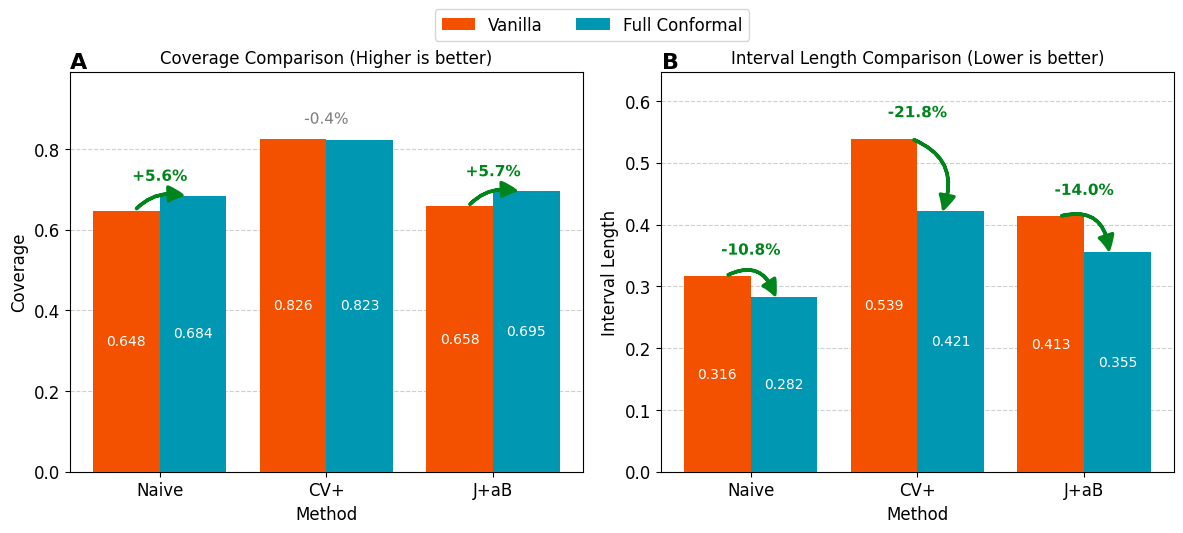

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import matplotlib.patheffects as PathEffects

# Your original data - unchanged
conformal_metrics_vanilla = {
 "cutoff": [0.0, 0.005404300522059202, 0.033684518188238144, 0.05, 0.1, 0.2, 0.3, 0.3890679180622101, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95],
"coverage_naive": [0.7387387387387387, 0.7063318777292577, 0.6786885245901639, 0.6776429809358753, 0.6897880539499036, 0.6666666666666666, 0.6122448979591837, 0.6524590163934426, 0.6732673267326733, 0.6692307692307692, 0.6291666666666667, 0.5866666666666667, 0.5720930232558139, 0.599009900990099, 0.5906432748538012, 0.6186440677966102],
"coverage_cv_plus": [0.8124488124488124, 0.8220524017467249, 0.8081967213114755, 0.8318890814558059, 0.7880539499036608, 0.7952380952380952, 0.7784256559766763, 0.8622950819672132, 0.8250825082508251, 0.8384615384615385, 0.8166666666666667, 0.8177777777777778, 0.8325581395348837, 0.8811881188118812, 0.8713450292397661, 0.8305084745762712],
"coverage_jackknife_plus_ab": [0.7371007371007371, 0.7030567685589519, 0.6983606557377049, 0.7036395147313691, 0.6994219653179191, 0.65, 0.597667638483965, 0.6786885245901639, 0.6666666666666666, 0.6923076923076923, 0.6375, 0.6, 0.5953488372093023, 0.6386138613861386, 0.6198830409356725, 0.6101694915254238],
"interval_width_naive": [0.33615486145019524, 0.3936747789382934, 0.466556578874588, 0.49313491582870483, 0.487522155046463, 0.5079672932624817, 0.49069738388061523, 0.44034600257873535, 0.4177010893821716, 0.263324589729309, 0.1493734073638917, 0.15726344108581536, 0.14645690917968746, 0.10872319698333734, 0.11693801879882804, 0.08713016510009772],
"interval_width_cv_plus": [0.4668159315342589, 0.586368582336256, 0.7235728639830667, 0.7403800183014566, 0.7302039602808726, 0.7549307892043143, 0.7676098270888058, 0.7277213052921607, 0.7387384294998208, 0.5471554418948408, 0.4016485076894363, 0.35569797782037, 0.34765150171449016, 0.2791582903140547, 0.25024804303956305, 0.2040898787899543],
"interval_width_jackknife_plus_ab": [0.36039082529103555, 0.46384172792555495, 0.556070822257092, 0.5413734147596377, 0.539451971366545, 0.5724188050525243, 0.5658157869805662, 0.5073035879693213, 0.5271816855408832, 0.4149356539053507, 0.3260407831630946, 0.28178233859655377, 0.275307510405132, 0.2507502335634401, 0.24274082546734074, 0.18510055958909732]
}

conformal_metrics_full = {
 "cutoff": [0.0, 0.02019340731203556, 0.05, 0.08336329460144043, 0.1, 0.2, 0.3, 0.3942202627658844, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95],
"coverage_naive": [0.7452907452907452, 0.7417582417582418, 0.7130177514792899, 0.6967213114754098, 0.6843003412969283, 0.7184684684684685, 0.7402234636871509, 0.7275862068965517, 0.7047244094488189, 0.6533333333333333, 0.6313131313131313, 0.6538461538461539, 0.6692913385826772, 0.6019417475728155, 0.5777777777777777],
"coverage_cv_plus": [0.8026208026208026, 0.8274725274725274, 0.8239644970414202, 0.8114754098360656, 0.8020477815699659, 0.8175675675675675, 0.8100558659217877, 0.8172413793103448, 0.8267716535433071, 0.8088888888888889, 0.8232323232323232, 0.9038461538461539, 0.84251968503937, 0.8252427184466019, 0.8],
"coverage_jackknife_plus_ab": [0.7510237510237511, 0.743956043956044, 0.7366863905325444, 0.7081967213114754, 0.6945392491467577, 0.7117117117117117, 0.6927374301675978, 0.696551724137931, 0.6968503937007874, 0.6755555555555556, 0.6363636363636364, 0.6346153846153846, 0.6456692913385826, 0.7184466019417476, 0.6888888888888889],
"interval_width_naive": [0.322261244058609, 0.40983694791793823, 0.48056086897850037, 0.4802219867706299, 0.46945762634277344, 0.5350031852722168, 0.5142185688018799, 0.3193846702575684, 0.2116791915893554, 0.15133106946945185, 0.09953787326812737, 0.06926748275756832, 0.06730165958404541, 0.06365835905075065, 0.041161084175109774],
"interval_width_cv_plus": [0.4185412854836212, 0.5398344419704197, 0.6410543321871843, 0.6636718530707275, 0.6900948589100142, 0.6846545961404823, 0.6774929595878088, 0.5892208908485441, 0.4004148539921313, 0.3097164634916517, 0.20581690796547467, 0.15928808751396645, 0.13721544881974615, 0.12202947386983529, 0.08167739729748831],
"interval_width_jackknife_plus_ab": [0.36390308438205504, 0.44925150174469797, 0.5222394097007471, 0.5368396887135725, 0.5508325172156908, 0.5615734695823149, 0.5558552061604769, 0.4378218054687386, 0.3351707858856022, 0.2610127360180157, 0.18176604478649605, 0.1578344907225396, 0.1364895012324654, 0.1573999745364928, 0.12151573378974767]
}

# Calculate averages for all metrics
def calculate_average_metrics(metrics_dict):
    avg_metrics = {
        'coverage_naive': np.mean(metrics_dict['coverage_naive']),
        'coverage_cv_plus': np.mean(metrics_dict['coverage_cv_plus']),
        'coverage_jackknife_plus_ab': np.mean(metrics_dict['coverage_jackknife_plus_ab']),
        'interval_width_naive': np.mean(metrics_dict['interval_width_naive']),
        'interval_width_cv_plus': np.mean(metrics_dict['interval_width_cv_plus']),
        'interval_width_jackknife_plus_ab': np.mean(metrics_dict['interval_width_jackknife_plus_ab'])
    }
    return avg_metrics

# Calculate the averages
vanilla_avg = calculate_average_metrics(conformal_metrics_vanilla)
full_avg = calculate_average_metrics(conformal_metrics_full)

# Calculate percentage differences
diff_coverage_naive = (full_avg['coverage_naive'] - vanilla_avg['coverage_naive']) / vanilla_avg['coverage_naive'] * 100
diff_coverage_cv_plus = (full_avg['coverage_cv_plus'] - vanilla_avg['coverage_cv_plus']) / vanilla_avg['coverage_cv_plus'] * 100
diff_coverage_jackknife = (full_avg['coverage_jackknife_plus_ab'] - vanilla_avg['coverage_jackknife_plus_ab']) / vanilla_avg['coverage_jackknife_plus_ab'] * 100

diff_interval_naive = (vanilla_avg['interval_width_naive'] - full_avg['interval_width_naive']) / vanilla_avg['interval_width_naive'] * 100
diff_interval_cv_plus = (vanilla_avg['interval_width_cv_plus'] - full_avg['interval_width_cv_plus']) / vanilla_avg['interval_width_cv_plus'] * 100
diff_interval_jackknife = (vanilla_avg['interval_width_jackknife_plus_ab'] - full_avg['interval_width_jackknife_plus_ab']) / vanilla_avg['interval_width_jackknife_plus_ab'] * 100

# Create the visualization
width = 0.4  # Adjusted bar width
methods = ['Naive', 'CV+', 'J+aB']
x = np.arange(len(methods))

# Set up color scheme
vanilla_color = '#F35000'  # Vibrant orange
conformal_color = '#0097B2'  # Vibrant teal
pos_color = '#00851D'  # Stronger green for better visibility
neg_color = '#D01C1C'  # Stronger red for better visibility

# Create figure with standard proportions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.rcParams.update({'font.size': 12})  # Set base font size

# === COVERAGE COMPARISON (Panel A) ===
vanilla_coverage = [vanilla_avg['coverage_naive'], vanilla_avg['coverage_cv_plus'], vanilla_avg['coverage_jackknife_plus_ab']]
full_coverage = [full_avg['coverage_naive'], full_avg['coverage_cv_plus'], full_avg['coverage_jackknife_plus_ab']]

# Format values to 3 decimal places for consistency
vanilla_coverage_formatted = [f"{val:.3f}" for val in vanilla_coverage]
full_coverage_formatted = [f"{val:.3f}" for val in full_coverage]

bar1 = ax1.bar(x - width/2, vanilla_coverage, width, label='Vanilla', color=vanilla_color, zorder=5)
bar2 = ax1.bar(x + width/2, full_coverage, width, label='Full Conformal', color=conformal_color, zorder=5)

# Function to add centered labels in bars
def add_centered_labels(bars, formatted_values, ax):
    for bar, value in zip(bars, formatted_values):
        height = bar.get_height()
        # Position labels in the middle of the bars
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                value, ha='center', va='center', fontsize=10, zorder=10,
                color='white')  # White text for contrast

add_centered_labels(bar1, vanilla_coverage_formatted, ax1)
add_centered_labels(bar2, full_coverage_formatted, ax1)

# Set coverage y-axis to start at 0 for accurate visual comparison
ax1.set_ylim(0, max(max(vanilla_coverage), max(full_coverage)) * 1.2)  # Increased padding for labels

ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=12)
ax1.set_xlabel('Method', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.set_title('Coverage Comparison (Higher is better)', fontsize=12)

# Reduce number of grid lines for less clutter
ax1.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
ax1.set_axisbelow(True)  # Ensure grid is behind bars

# === INTERVAL WIDTH COMPARISON (Panel B) ===
vanilla_interval = [vanilla_avg['interval_width_naive'], vanilla_avg['interval_width_cv_plus'], vanilla_avg['interval_width_jackknife_plus_ab']]
full_interval = [full_avg['interval_width_naive'], full_avg['interval_width_cv_plus'], full_avg['interval_width_jackknife_plus_ab']]

# Format values to 3 decimal places for consistency
vanilla_interval_formatted = [f"{val:.3f}" for val in vanilla_interval]
full_interval_formatted = [f"{val:.3f}" for val in full_interval]

bar3 = ax2.bar(x - width/2, vanilla_interval, width, color=vanilla_color, zorder=5)
bar4 = ax2.bar(x + width/2, full_interval, width, color=conformal_color, zorder=5)

add_centered_labels(bar3, vanilla_interval_formatted, ax2)
add_centered_labels(bar4, full_interval_formatted, ax2)

# Set interval y-axis to start at 0
ax2.set_ylim(0, max(max(vanilla_interval), max(full_interval)) * 1.2)  # Increased padding for labels

ax2.set_xticks(x)
ax2.set_xticklabels(methods, fontsize=12)
ax2.set_xlabel('Method', fontsize=12)
ax2.set_ylabel('Interval Length', fontsize=12)
ax2.set_title('Interval Length Comparison (Lower is better)', fontsize=12)

# Reduce number of grid lines for less clutter
ax2.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
ax2.set_axisbelow(True)  # Ensure grid is behind bars

# === ARROWS AND LABELS WITH MORE CURVE ===
arrow_style = "simple,head_width=10,head_length=10"
arrow_linewidth = 2.5

# Add curved arrows
coverage_diffs = [diff_coverage_naive, diff_coverage_cv_plus, diff_coverage_jackknife]
interval_diffs = [diff_interval_naive, diff_interval_cv_plus, diff_interval_jackknife]

for i, (diff_cov, diff_int) in enumerate(zip(coverage_diffs, interval_diffs)):
    # Coverage arrows and annotations
    vanilla_bar_top = vanilla_coverage[i]
    full_bar_top = full_coverage[i]
    arrow_center_x = x[i]
    
    # For coverage: higher is better
    if diff_cov > 1.0:  # Only show significant improvements (>1%)
        # Draw curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        
        # Add text with percentage improvement
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'+{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=11, color=pos_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    elif diff_cov < -1.0:  # Only show significant decreases (<-1%)
        # Draw curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=neg_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        
        # Add text with percentage decrease
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'{diff_cov:.1f}%', ha='center', va='bottom', 
                fontsize=11, color=neg_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    else:
        # For the -0.4% case (essentially equivalent), show a muted label
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'{diff_cov:.1f}%', ha='center', va='bottom', 
                fontsize=11, color='#666666', fontweight='normal', alpha=0.8)
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    
    # Interval width arrows and annotations - WITH MORE CURVED ARROWS
    vanilla_bar_top_int = vanilla_interval[i]
    full_bar_top_int = full_interval[i]
    
    # For interval: lower is better
    if diff_int > 0:  # Full conformal has shorter interval (better)
        # Special adjustment for each method to match the J+aB arrow style
        start_x_offset = 0.05
        end_x_offset = 0.05
        curve_rad = -0.6
        
        if i == 1:  # CV+ method - Make it match J+aB
            # Get the settings used for J+aB (index 2)
            start_x_offset = 0.165  # Use the same offset as J+aB
            end_x_offset = 0.05    # Use the same offset as J+aB
            curve_rad = -0.5       # Use slightly less curve to match appearance
        
        # Draw curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + start_x_offset, vanilla_bar_top_int), 
            (arrow_center_x + width/2 - end_x_offset, full_bar_top_int),
            connectionstyle=f"arc3,rad={curve_rad}", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax2.add_patch(arrow)
        
        # Position text above the bar for better visibility
        text = ax2.text(arrow_center_x, max(vanilla_bar_top_int, full_bar_top_int) + 0.03,
                f'-{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=11, color=pos_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

# Add legend with standard styling
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12, 
          bbox_to_anchor=(0.5, 0.95), frameon=True)

# Add letters A and B to the subplots
ax1.text(0.035, 1.05, 'A', transform=ax1.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(0.035, 1.05, 'B', transform=ax2.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.9])

# plt.savefig('matched_arrow_styles.png', dpi=400, bbox_inches='tight')
plt.show()